### Three connected nodes

In [1]:
import sys

sys.path.insert(1, "/home/vinicius/Documentos/phase_amplitude_encoding/")

In [2]:
import jax
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from frites.core import copnorm_nd
from hoi.core import get_mi
from mne.time_frequency.tfr import tfr_array_morlet
from tqdm import tqdm

from src.models import simulate, simulate_delayed

/home/vinicius/anaconda3/envs/test_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
jax.config.update("jax_platform_name", "cpu")

#### Simulation parameters

In [4]:
Nareas = 3
ntrials = 50
fsamp = 1 / 1e-4

time = np.arange(-8, 2, 1 / fsamp)
beta = 1e-4
Npoints = len(time)
decim = 15

C = np.array([[0, 1, 0], [0, 0, 1], [0, 0, 0]]).T

f = 40

In [5]:
Iext = np.zeros((Nareas, Npoints))
Iext[0, (time >= 0) & (time <= 0.4)] = 1
Amplitudes = np.linspace(0, 0.1, ntrials)
CS = Amplitudes[..., None, None] * Iext
seeds = np.random.randint(0, 10000, ntrials)

In [6]:
out = []
for trial in tqdm(range(ntrials)):
    out += [
        simulate(
            C,
            1,
            f,
            np.array([-8, -5, -3]),
            fsamp,
            beta,
            Npoints,
            CS[trial],
            seeds[trial],
            decim=decim,
            stim_mode="both",
        )
    ]

100%|████████████████████████████████████████████████████████| 50/50 [00:52<00:00,  1.04s/it]


In [7]:
stim = np.arange(ntrials)
data = xr.DataArray(
    np.stack(out),
    dims=("trials", "roi", "times"),
    coords=(stim, ["x", "y", "z"], time[::decim]),
).sel(times=slice(-2, 2))

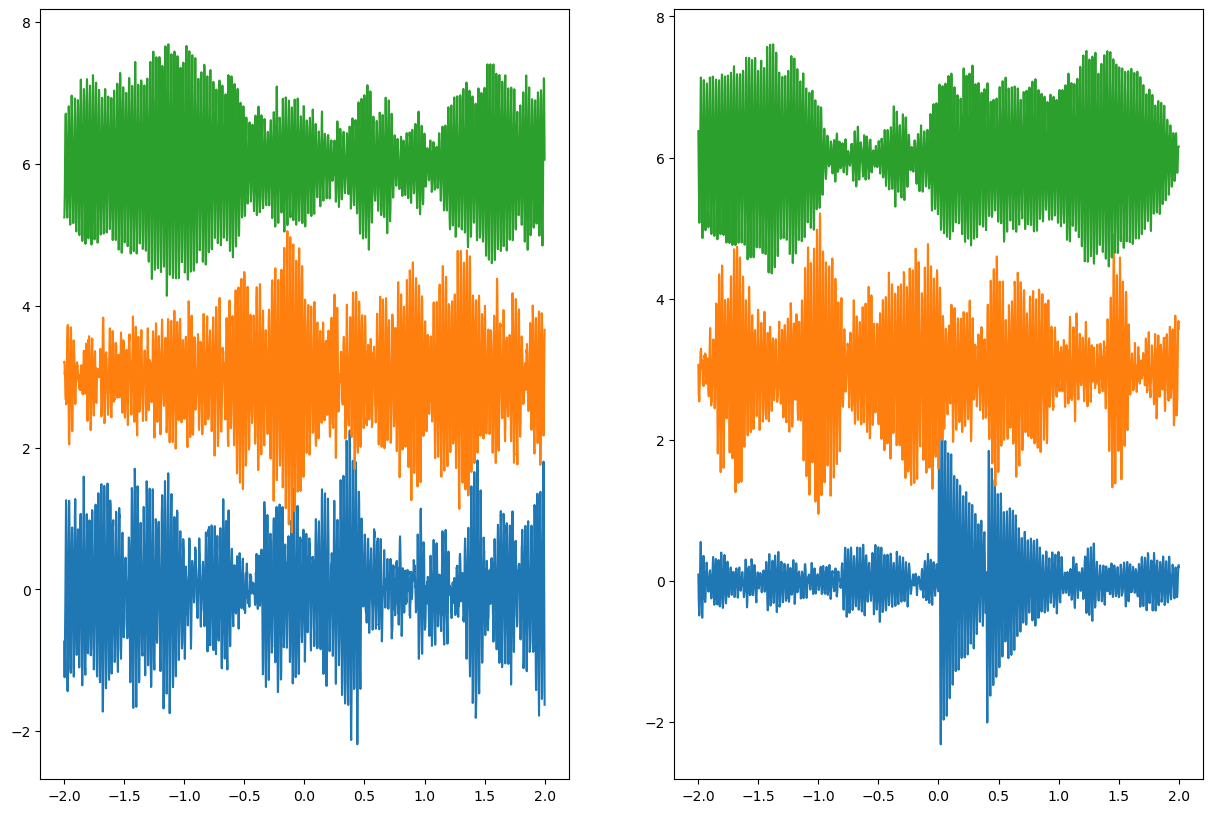

In [8]:
plt.figure(figsize=(15, 10))
z_data = (data - data.mean("times")) / data.std("times")
plt.subplot(1, 2, 1)
for i in range(Nareas):
    plt.plot(z_data[-1].times, z_data[0].values[i].real + (i * 3))
plt.subplot(1, 2, 2)
for i in range(Nareas):
    plt.plot(z_data[-1].times, z_data[-1].values[i].real + (i * 3))

(0.0, 0.5)

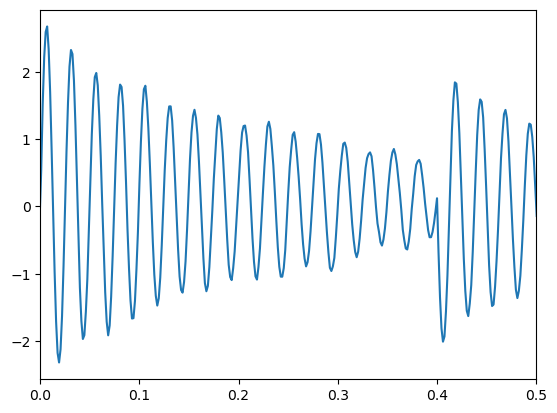

In [9]:
i = 0
plt.plot(z_data[-1].times, z_data[-1].values[i].real + (i * 3))
plt.xlim(0, 0.5)

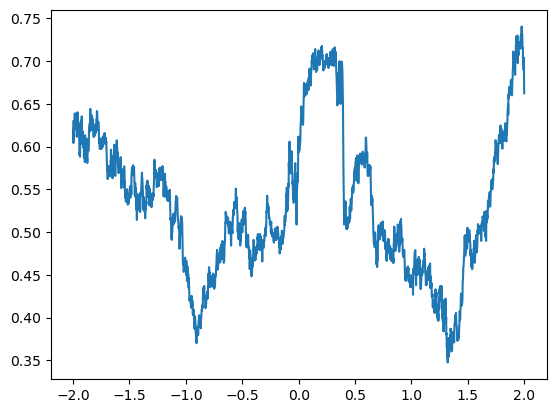

In [10]:
import scipy

theta = np.angle(scipy.signal.hilbert(data.real, axis=2))

plt.plot(data.times, np.abs(np.exp(1j * theta).mean(axis=1)).mean(0))

#### Computing MI

In [11]:
from spectralMI import spectralMI

In [12]:
freqs = np.linspace(0.3, 80, 50)

MI = spectralMI(
    data,
    stim,
    freqs,
    roi="roi",
    times="times",
    n_cycles=freqs / 7,
    n_jobs=1,
    mode="phase",
)

Defining links (n_roi=3; directed=False; net=False, nb_min_links=None)
    Sorting roi names
Computing pairwise spectral MI (n_pairs=3, n_freqs=50, decim=1)
100%|██████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.00s/it]


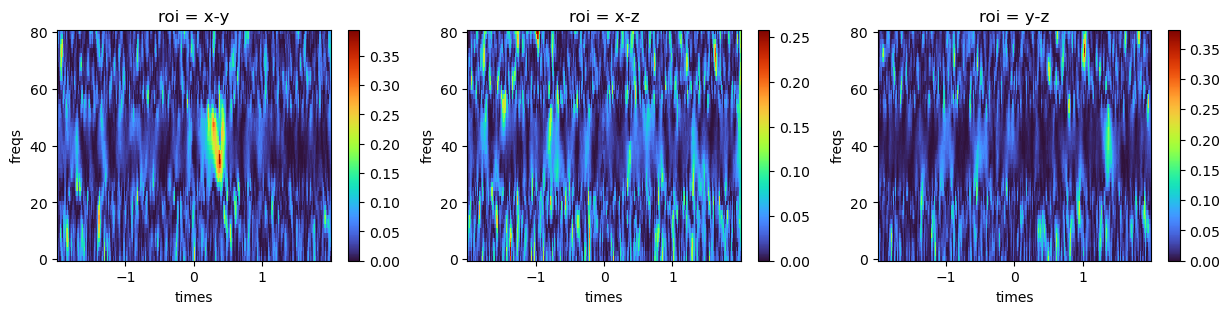

In [13]:
plt.figure(figsize=(15, 3))
pos = 1
for roi in MI.roi.values:
    plt.subplot(1, 3, pos)
    MI.sel(roi=roi).plot(cmap="turbo", vmin=0)
    pos = pos + 1

In [14]:
freqs = np.linspace(0.3, 80, 50)

MI = spectralMI(
    data,
    stim,
    freqs,
    roi="roi",
    times="times",
    n_cycles=freqs / 7,
    n_jobs=2,
    mode="phase_amplitude",
)

Defining links (n_roi=3; directed=False; net=False, nb_min_links=None)
    Sorting roi names
Computing pairwise spectral MI (n_pairs=3, n_freqs=50, decim=1)
/home/vinicius/anaconda3/envs/test_env/lib/python3.11/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:    2.0s finished
100%|██████████████████████████████████████████████████████████| 3/3 [00:14<00:00,  4.83s/it]


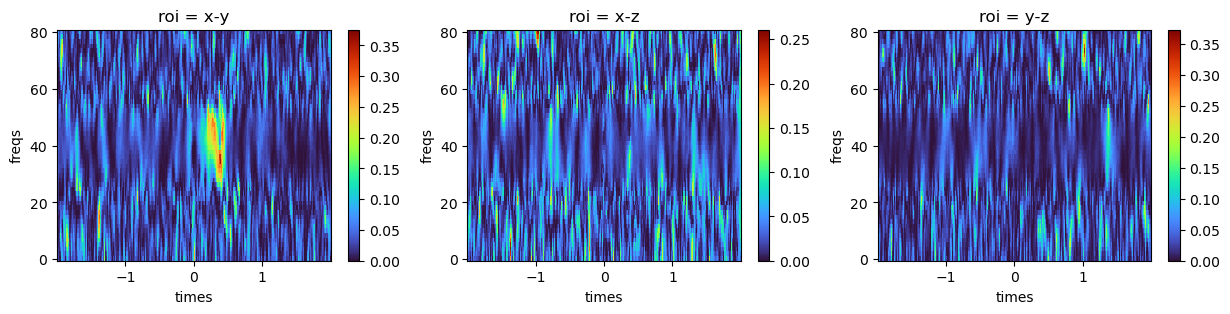

In [15]:
plt.figure(figsize=(15, 3))
pos = 1
for roi in MI.roi.values:
    plt.subplot(1, 3, pos)
    MI.sel(roi=roi).plot(cmap="turbo", vmin=0)
    pos = pos + 1